# Augmentation  
----

In [4]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

print('=3')

=3


In [5]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [6]:
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)


print('=3')

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/stanford_dogs/0.2.0.incompleteSY1ZC3/stanford_dogs-train.tfrecord


  0%|          | 0/12000 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/stanford_dogs/0.2.0.incompleteSY1ZC3/stanford_dogs-test.tfrecord


  0%|          | 0/8580 [00:00<?, ? examples/s]

Dataset stanford_dogs downloaded and prepared to /root/tensorflow_datasets/stanford_dogs/0.2.0. Subsequent calls will reuse this data.
=3


In [7]:
def normalize_and_resize_img(image, label):
    # Normalizes images: `uint8` -> `float32`
    image = tf.image.resize(image, [224, 224])
    return tf.cast(image, tf.float32) / 255., label

In [8]:
def augment(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    return image, label

In [9]:
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16, with_aug=False):
    ds = ds.map(
        normalize_and_resize_img,  # 기본적인 전처리 함수 적용
        num_parallel_calls=2
    )
    if not is_test and with_aug:
        ds = ds.map(
            augment,       # augment 함수 적용
            num_parallel_calls=2
        )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [10]:
ds_train_no_aug = apply_normalize_on_dataset(ds_train, with_aug=False)

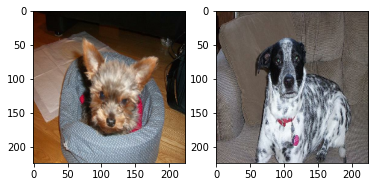

In [11]:
for i, (image, label) in enumerate(ds_train_no_aug.take(1)):
    if i == 0:
        image_a = image[0]
        image_b = image[1]
        label_a = label[0]
        label_b = label[1]
        break

plt.subplot(1,2,1)
plt.imshow(image_a)

plt.subplot(1,2,2)
plt.imshow(image_b)

In [12]:
def get_clip_box(image_a, image_b):
    # image.shape = (height, width, channel)
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0]
    
    # get center of box
    x = tf.cast( tf.random.uniform([],0, image_size_x),tf.int32)
    y = tf.cast( tf.random.uniform([],0, image_size_y),tf.int32)

    # get width, height of box
    width = tf.cast(image_size_x * tf.math.sqrt(1-tf.random.uniform([],0,1)),tf.int32)
    height = tf.cast(image_size_y * tf.math.sqrt(1-tf.random.uniform([],0,1)),tf.int32)
    
    # clip box in image and get minmax bbox
    xa = tf.math.maximum(0, x-width//2)
    ya = tf.math.maximum(0, y-height//2)
    xb = tf.math.minimum(image_size_x, x+width//2)
    yb = tf.math.minimum(image_size_y, y+height//2)
    
    return xa, ya, xb, yb

In [13]:
# mix two images
def mix_2_images(image_a, image_b, xa, ya, xb, yb):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0]
    one = image_a[ya:yb,0:xa,:]
    two = image_b[ya:yb,xa:xb,:]
    three = image_a[ya:yb,xb:image_size_x,:]
    middle = tf.concat([one,two,three],axis=1)
    top = image_a[0:ya,:,:]
    bottom = image_a[yb:image_size_y,:,:]
    mixed_img = tf.concat([top, middle, bottom],axis=0)
    
    return mixed_img

In [14]:
def onehot(image, label, num_classes=120):
    
    label =tf.one_hot(label, num_classes)
    
    return image,label

In [15]:
def mix_2_label(label_a, label_b, xa, ya, xb, yb, num_classes=120):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    mixed_area = (xb-xa)*(yb-ya)
    total_area = image_size_x*image_size_y
    a = tf.cast(mixed_area/total_area, tf.float32)

    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_label = (1-a)*label_a + a*label_b
    return mixed_label

In [16]:
def cutmix(image, label, prob = 1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0, batch_size),tf.int32)
        image_b = image[j]
        label_b = label[j]
        xa, ya, xb, yb = get_clip_box(image_a, image_b)
        mixed_imgs.append(mix_2_images(image_a, image_b, xa, ya, xb, yb))
        mixed_labels.append(mix_2_label(label_a, label_b, xa, ya, xb, yb))

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs),(batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels),(batch_size, num_classes))
    return mixed_imgs, mixed_labels

In [17]:
# function for mixup
def mixup_2_images(image_a, image_b, label_a, label_b, num_classes = 120):
    ratio = tf.random.uniform([], 0, 1)
    
    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_image= (1-ratio)*image_a + ratio*image_b
    mixed_label = (1-ratio)*label_a + ratio*label_b
    
    return mixed_image, mixed_label

In [18]:
def mixup(image, label, prob=1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0,batch_size), tf.int32)
        image_b = image[j]
        label_b = label[j]
        mixed_img, mixed_label = mixup_2_images(image_a, image_b, label_a, label_b)
        mixed_imgs.append(mixed_img)
        mixed_labels.append(mixed_label)

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels

In [19]:
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16, with_aug=False,
                               with_cutmix=False, with_mixup = False):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=2
    )
    
    if not is_test and with_aug:
        ds = ds.map(
            augment
        )
    ds = ds.batch(batch_size)
    if not is_test and with_cutmix:
        ds = ds.map(
            cutmix,
            num_parallel_calls=2
        )

    elif not is_test and with_mixup:
        ds = ds.map(
            mixup,
            num_parallel_calls=2
        )        

    else:
        ds = ds.map(
            onehot,
            num_parallel_calls=2
        )
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds


In [20]:
ds_train_no_aug = apply_normalize_on_dataset(ds_train, with_aug=False) 
ds_train_aug = apply_normalize_on_dataset(ds_train, with_aug=True)
ds_train_cutmix = apply_normalize_on_dataset(ds_train, with_cutmix=True)  
ds_train_mixup = apply_normalize_on_dataset(ds_train, with_mixup=True)  
ds_test = apply_normalize_on_dataset(ds_test, is_test=True)

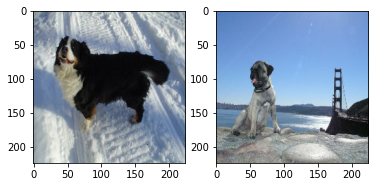

In [21]:
# 데이터셋에서 이미지 2개를 가져옵니다. 
for i, (image, label) in enumerate(ds_train_no_aug.take(1)):
    if i == 0:
        image_a = image[0]
        image_b = image[1]
        label_a = label[0]
        label_b = label[1]
        break

plt.subplot(1,2,1)
plt.imshow(image_a)

plt.subplot(1,2,2)
plt.imshow(image_b)

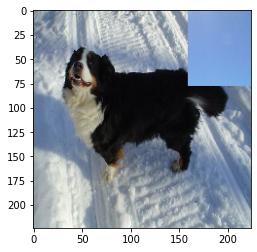

In [22]:
xa, ya, xb, yb = get_clip_box(image_a, image_b)
mixed_img = mix_2_images(image_a, image_b, xa, ya, xb, yb)
plt.imshow(mixed_img.numpy())

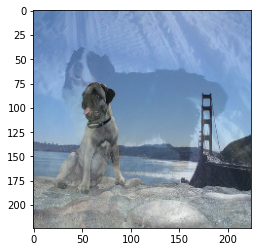

In [23]:
mixed_img, mixed_label = mixup_2_images(image_a, image_b, label_a, label_b)
plt.imshow(mixed_img.numpy())


In [24]:
num_classes = ds_info.features["label"].num_classes
resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])
print('=3')

94781440/94765736 [==============================] - 0s 0us/step
=3


In [25]:
aug_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])
print('=3')

=3


In [26]:
cutmix_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])
print('=3')

=3


In [27]:
mixup_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])
print('=3')

=3


In [28]:
#EPOCH = 20  # Augentation 적용 효과를 확인하기 위해 필요한 epoch 수
EPOCH = 20

In [29]:
resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
    metrics=['accuracy'],
)

In [30]:
aug_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
    metrics=['accuracy'],
)

In [31]:
cutmix_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
    metrics=['accuracy'],
)

In [32]:
mixup_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
    metrics=['accuracy'],
)

In [33]:
history_resnet50_no_aug = resnet50.fit(
    ds_train_no_aug, # augmentation 적용하지 않은 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
750/750 [==============================] - 169s 204ms/step - loss: 2.2311 - accuracy: 0.4426 - val_loss: 3.4375 - val_accuracy: 0.1960
Epoch 2/20
750/750 [==============================] - 158s 210ms/step - loss: 0.6931 - accuracy: 0.8134 - val_loss: 1.0152 - val_accuracy: 0.6958
Epoch 3/20
750/750 [==============================] - 159s 212ms/step - loss: 0.1773 - accuracy: 0.9696 - val_loss: 0.9256 - val_accuracy: 0.7294
Epoch 4/20
750/750 [==============================] - 158s 211ms/step - loss: 0.0481 - accuracy: 0.9968 - val_loss: 0.9005 - val_accuracy: 0.7383
Epoch 5/20
750/750 [==============================] - 159s 212ms/step - loss: 0.0196 - accuracy: 0.9998 - val_loss: 0.9056 - val_accuracy: 0.7387
Epoch 6/20
750/750 [==============================] - 158s 211ms/step - loss: 0.0126 - accuracy: 1.0000 - val_loss: 0.9218 - val_accuracy: 0.7404
Epoch 7/20
750/750 [==============================] - 159s 212ms/step - loss: 0.0095 - accuracy: 1.0000 - val_loss: 0.9338 -

In [34]:
history_resnet50_aug = aug_resnet50.fit(
    ds_train_aug, # augmentation 적용한 데이터 셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
750/750 [==============================] - 165s 212ms/step - loss: 2.2539 - accuracy: 0.4346 - val_loss: 2.9446 - val_accuracy: 0.2768
Epoch 2/20
750/750 [==============================] - 158s 211ms/step - loss: 0.8709 - accuracy: 0.7544 - val_loss: 1.2079 - val_accuracy: 0.6530
Epoch 3/20
750/750 [==============================] - 158s 211ms/step - loss: 0.4284 - accuracy: 0.8889 - val_loss: 1.1937 - val_accuracy: 0.6599
Epoch 4/20
750/750 [==============================] - 158s 211ms/step - loss: 0.2047 - accuracy: 0.9551 - val_loss: 1.2307 - val_accuracy: 0.6610
Epoch 5/20
750/750 [==============================] - 158s 211ms/step - loss: 0.1046 - accuracy: 0.9836 - val_loss: 0.9764 - val_accuracy: 0.7257
Epoch 6/20
750/750 [==============================] - 159s 212ms/step - loss: 0.0594 - accuracy: 0.9924 - val_loss: 0.9743 - val_accuracy: 0.7381
Epoch 7/20
750/750 [==============================] - 158s 211ms/step - loss: 0.0478 - accuracy: 0.9940 - val_loss: 0.9549 -

In [35]:
history_resnet50_cutmix = cutmix_resnet50.fit(
    ds_train_cutmix, # cutmix 적용한 데이터 셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
750/750 [==============================] - 167s 213ms/step - loss: 3.8408 - accuracy: 0.2085 - val_loss: 3.5323 - val_accuracy: 0.1980
Epoch 2/20
750/750 [==============================] - 159s 212ms/step - loss: 2.9409 - accuracy: 0.4358 - val_loss: 1.3551 - val_accuracy: 0.6220
Epoch 3/20
750/750 [==============================] - 160s 213ms/step - loss: 2.6088 - accuracy: 0.5508 - val_loss: 1.2316 - val_accuracy: 0.6550
Epoch 4/20
750/750 [==============================] - 159s 213ms/step - loss: 2.4119 - accuracy: 0.6061 - val_loss: 1.2842 - val_accuracy: 0.6512
Epoch 5/20
750/750 [==============================] - 159s 213ms/step - loss: 2.2461 - accuracy: 0.6565 - val_loss: 1.3349 - val_accuracy: 0.6428
Epoch 6/20
750/750 [==============================] - 159s 212ms/step - loss: 2.1637 - accuracy: 0.6864 - val_loss: 1.1887 - val_accuracy: 0.6863
Epoch 7/20
750/750 [==============================] - 159s 212ms/step - loss: 2.0303 - accuracy: 0.7285 - val_loss: 1.1356 -

In [36]:
history_resnet50_mixup = mixup_resnet50.fit(
    ds_train_mixup, # mixup 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
750/750 [==============================] - 166s 213ms/step - loss: 3.7291 - accuracy: 0.2412 - val_loss: 3.8214 - val_accuracy: 0.1438
Epoch 2/20
750/750 [==============================] - 159s 212ms/step - loss: 2.8729 - accuracy: 0.4762 - val_loss: 1.4501 - val_accuracy: 0.5969
Epoch 3/20
750/750 [==============================] - 159s 212ms/step - loss: 2.5812 - accuracy: 0.5790 - val_loss: 1.2955 - val_accuracy: 0.6376
Epoch 4/20
750/750 [==============================] - 159s 212ms/step - loss: 2.3763 - accuracy: 0.6547 - val_loss: 1.3311 - val_accuracy: 0.6280
Epoch 5/20
750/750 [==============================] - 159s 212ms/step - loss: 2.2382 - accuracy: 0.7164 - val_loss: 1.2612 - val_accuracy: 0.6532
Epoch 6/20
750/750 [==============================] - 159s 212ms/step - loss: 2.1510 - accuracy: 0.7465 - val_loss: 1.1683 - val_accuracy: 0.6849
Epoch 7/20
750/750 [==============================] - 159s 212ms/step - loss: 2.0537 - accuracy: 0.7814 - val_loss: 1.2333 -

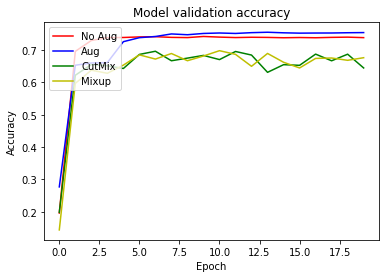

In [37]:
plt.plot(history_resnet50_no_aug.history['val_accuracy'], 'r')
plt.plot(history_resnet50_aug.history['val_accuracy'], 'b')
plt.plot(history_resnet50_cutmix.history['val_accuracy'], 'g')
plt.plot(history_resnet50_mixup.history['val_accuracy'], 'y')



plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Aug', 'Aug','CutMix','Mixup'], loc='upper left')
plt.show()

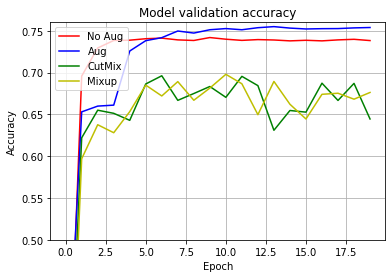

In [38]:
plt.plot(history_resnet50_no_aug.history['val_accuracy'], 'r')
plt.plot(history_resnet50_aug.history['val_accuracy'], 'b')
plt.plot(history_resnet50_cutmix.history['val_accuracy'], 'g')
plt.plot(history_resnet50_mixup.history['val_accuracy'], 'y')





plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Aug', 'Aug','CutMix','Mixup'], loc='upper left')
plt.grid(True)
plt.ylim(0.50, 0.76) 
plt.show()

### 회고  
----  
cutmix와 mixup은 몇번을 돌려도 No augmentation과 기본적인 augmentation의 성능을 따라오지 못했다. epoch이 적어서 그런건진 모르겠지만 개선할 수 있을지는 의문. 한가지 눈에 들어온 것은 폐렴 노드때와 다르게 Augmentation을 진행한 경우가 No augmentation의 모델보다 성능이 좋게 나왔다는 것이다. augmetation에 대한 큰 기대를 하지 않았었는데 이번 노드를 수행하면서 생각이 좀 바뀐 듯 하다. 그리고 저번 미제출의 여파인지 크게 의욕이 없었음... ㅎㅎ 아쉽다.